In [59]:
import torch

torch.__version__

'2.6.0'

### Make the classification data ready

In [60]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y  = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

In [61]:
len(X), len(y), X.shape

(1000, 1000, (1000, 2))

In [62]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

### VIsualize Visualize Visulaize

In [63]:
## Visualize
import matplotlib.pyplot as plt
import pandas as pd


data = pd.DataFrame({"X1" : X[:,0], "X2": X[:,1], "label" : y})
data

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


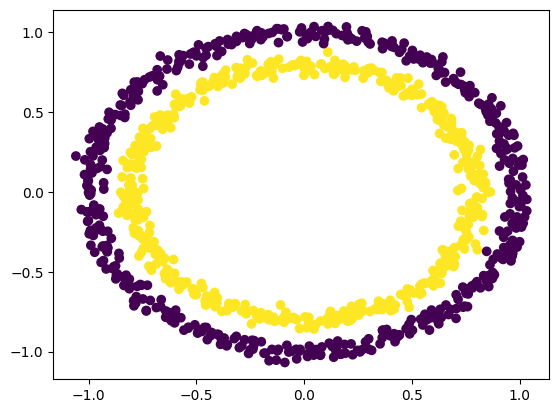

In [64]:
plt.scatter(data["X1"], data["X2"],c=y )

### Convert the data into Tensors

In [65]:
type(X) 

## convert numpy array to tensor

numpy.ndarray

In [66]:
X.shape, y.shape
# X have 1000 sample with 2 features, and y is a scalar

((1000, 2), (1000,))

In [67]:
import torch

Xs = torch.from_numpy(X).type(torch.float32)
ys = torch.from_numpy(y).type(torch.float32)



In [68]:
Xs

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]])

In [69]:
type(Xs)

torch.Tensor

### Split the data into train ,test

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xs,ys, train_size=0.8, test_size=0.2, random_state=42)

In [87]:
len(X_train), len(X_test)



(800, 200)

### Set up device agonostic codew

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

### Create a model

In [73]:
from torch import nn
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # create the linear layers
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer2(self.layer1(x))

In [74]:
model_0 = CircleModelV1().to(device)

next(model_0.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], requires_grad=True)

In [75]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer1.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer2.bias', tensor([-0.2060]))])

In [76]:
next(model_0.parameters()).device

device(type='cpu')

In [77]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], requires_grad=True)

In [78]:
# to find all the layers
model_0

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [79]:
# Untrained Prediction
model_0.eval()

with torch.inference_mode():
    untrained_preds = model_0(X_train.to(device))

In [80]:
untrained_preds[:5]

tensor([[-0.1420],
        [-0.1567],
        [-0.1939],
        [-0.1973],
        [-0.1124]])

### Setup Loss Fn and Optimizer

In [81]:
# for classification , u can use Binary cross entropy or  categorical Cross entropy
loss_fn = nn.BCEWithLogitsLoss() # sigmoid function attached for binary class

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [82]:
# calculate accuracy

def accuracy_fn(y_pred, y_true):
    corrct = torch.eq(y_pred,y_true).sum().item()
    acc = (corrct/ len(y_true)) * 100
    return acc



### Train a Model

In [83]:
with torch.inference_mode():
    print(torch.round(torch.sigmoid(model_0(X_train[:5].to(device)))).squeeze())

tensor([0., 0., 0., 0., 0.])


In [84]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [103]:
# trainig loop
torch.manual_seed(42)
epochs = 1000
# putt everything device aganostic
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    model_0.train()
    # forward pass
    train_logits = model_0(X_train).squeeze()
    # convert logits into predition - pass the logits into sigmoid fn and round it / squueze the logits
    train_preds = torch.round(torch.sigmoid(train_logits))
    
    # calc the loss
    train_loss = loss_fn(train_logits, y_train)
    train_acc = accuracy_fn(train_preds, y_train)
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()
    
    # Eval
    model_0.eval()
    
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        
          # calc the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_preds, y_test)
        
        
        if epoch % 10 == 0 :
            print(f"Train Loss : {train_loss} | Test Loss : {test_loss} | Train accuracy : {train_acc}, | Test Accuracy : {test_acc}")
        

    


Train Loss : 0.6929803490638733 | Test Loss : 0.6947603821754456 | Train accuracy : 51.125, | Test Accuracy : 45.5
Train Loss : 0.6929803490638733 | Test Loss : 0.6947547197341919 | Train accuracy : 51.125, | Test Accuracy : 45.5
Train Loss : 0.6929802894592285 | Test Loss : 0.6947494745254517 | Train accuracy : 51.125, | Test Accuracy : 45.5
Train Loss : 0.692980170249939 | Test Loss : 0.6947445869445801 | Train accuracy : 51.125, | Test Accuracy : 45.5
Train Loss : 0.692980170249939 | Test Loss : 0.6947399377822876 | Train accuracy : 51.125, | Test Accuracy : 45.5
Train Loss : 0.692980170249939 | Test Loss : 0.6947357058525085 | Train accuracy : 51.24999999999999, | Test Accuracy : 45.5
Train Loss : 0.6929800510406494 | Test Loss : 0.6947317719459534 | Train accuracy : 51.24999999999999, | Test Accuracy : 45.5
Train Loss : 0.6929800510406494 | Test Loss : 0.6947280764579773 | Train accuracy : 51.24999999999999, | Test Accuracy : 45.5
Train Loss : 0.6929800510406494 | Test Loss : 0.69

In [105]:
# use helper function from goku mohandas repo
import requests
from pathlib import Path

if Path("./helpers.py").is_file():
    print("File already exist, no redownload needed")
else:
    print("Downloading file..")
    data = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py") 
    with open("./helpers.py", "wb") as f:
        f.write(data.content)
    
    
    

File already exist, no redownload needed


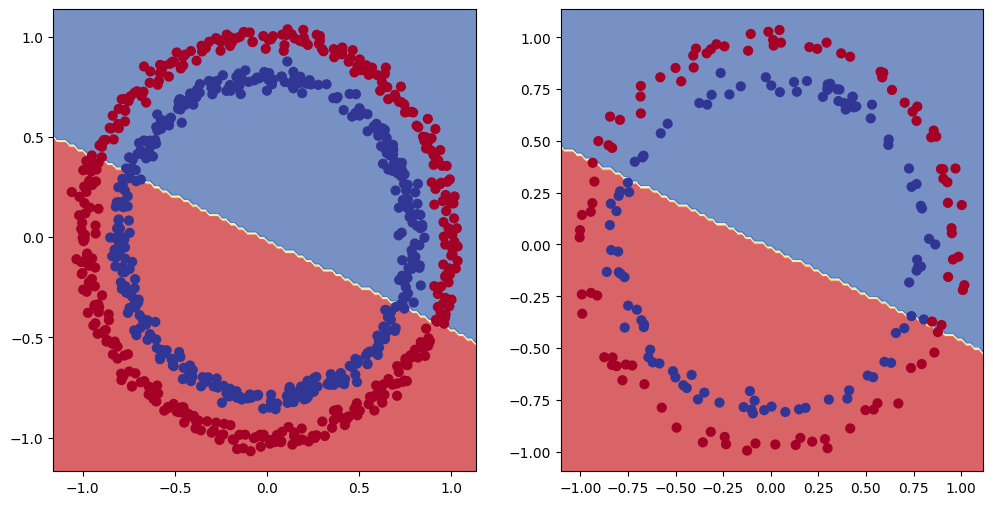

In [118]:
from helpers import plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_0,X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_0,X_test, y_test)

## Improve the model :  Unhappy with result

In [119]:
## Usig non linerar activations

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return  self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))


In [122]:
model_3 = CircleModelV2()

model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [123]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [124]:
## prepare a data into device
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train,  X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)


In [128]:
epochs = 1000

for epoch in range(epochs):
    model_3.train()
    # forward pass
    train_logits =  model_3(X_train).squeeze()
    train_preds  = torch.round(torch.sigmoid(train_logits))
    
    # calc the loss
    train_loss = loss_fn(train_logits, y_train)
    train_acc = accuracy_fn(train_preds, y_train)
    
    # optimize the grad
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()
    
    # eval
    
    model_3.eval()
    
    with torch.inference_mode():
        # forward pass
        test_logits =  model_3(X_test).squeeze()
        test_preds  = torch.round(torch.sigmoid(test_logits))
        
        # calc the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_preds, y_test)
        
        if epoch % 10 == 0 :
            print(f"Epooch : {epoch} | Train Loss : {train_loss} | Test Loss : {test_loss} | Train accuracy : {train_acc}, | Test Accuracy : {test_acc}")
        

    

        
        
        
    

Epooch : 0 | Train Loss : 0.6494488716125488 | Test Loss : 0.6591679453849792 | Train accuracy : 66.625, | Test Accuracy : 60.0
Epooch : 10 | Train Loss : 0.6475260257720947 | Test Loss : 0.6577512621879578 | Train accuracy : 66.875, | Test Accuracy : 59.0
Epooch : 20 | Train Loss : 0.645504891872406 | Test Loss : 0.6562349200248718 | Train accuracy : 66.875, | Test Accuracy : 59.0
Epooch : 30 | Train Loss : 0.6433767676353455 | Test Loss : 0.6546252965927124 | Train accuracy : 66.875, | Test Accuracy : 59.0
Epooch : 40 | Train Loss : 0.6411138772964478 | Test Loss : 0.6528985500335693 | Train accuracy : 67.25, | Test Accuracy : 59.0
Epooch : 50 | Train Loss : 0.6387413144111633 | Test Loss : 0.6510745286941528 | Train accuracy : 67.25, | Test Accuracy : 59.5
Epooch : 60 | Train Loss : 0.6362389922142029 | Test Loss : 0.6491097807884216 | Train accuracy : 67.125, | Test Accuracy : 60.5
Epooch : 70 | Train Loss : 0.6335822939872742 | Test Loss : 0.6470003724098206 | Train accuracy : 67.

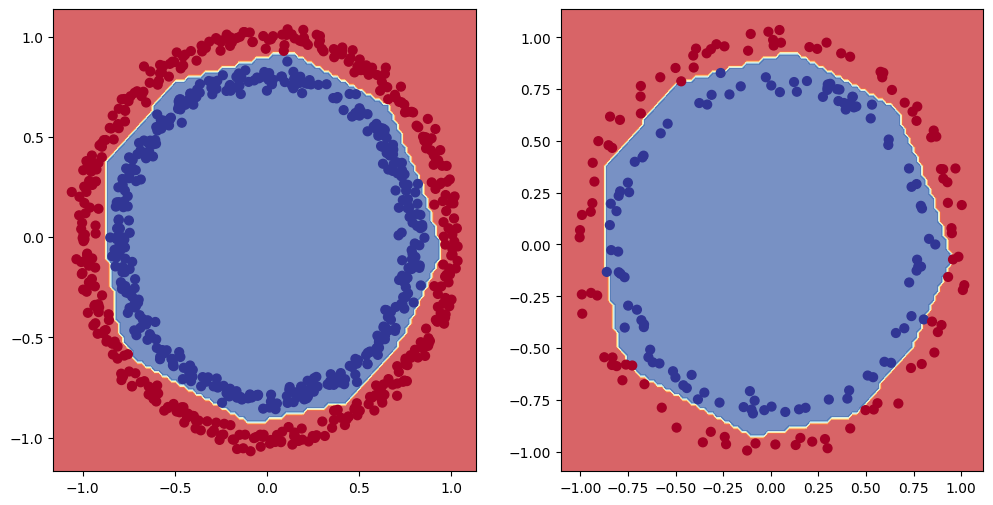

In [130]:
from helpers import plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_3,X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_3,X_test, y_test)